In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()



In [54]:
import os
import pandas as pd

os.makedirs('outputs', exist_ok=True)
os.makedirs('csv_files', exist_ok=True)

trades = pd.read_csv('/content/ds_Tanya/historical_data.csv')
sentiment = pd.read_csv('/content/ds_Tanya/fear_greed_index.csv')

trades.columns = trades.columns.str.lower().str.strip()
sentiment.columns = sentiment.columns.str.lower().str.strip()

print("Trades columns:", trades.columns.tolist())
print("Sentiment columns:", sentiment.columns.tolist())


Trades columns: ['account', 'coin', 'execution price', 'size tokens', 'size usd', 'side', 'timestamp ist', 'start position', 'direction', 'closed pnl', 'transaction hash', 'order id', 'crossed', 'fee', 'trade id', 'timestamp']
Sentiment columns: ['timestamp', 'value', 'classification', 'date']


In [55]:
import pandas as pd

timestamp_candidates = ['timestamp ist', 'timestamp_ist', 'timestamp', 'time']
for c in timestamp_candidates:
    if c in trades.columns:
        trades['timestamp'] = pd.to_datetime(trades[c], errors='coerce', dayfirst=True)
        break
else:
    raise KeyError("No timestamp-like column found in trades.")

if 'date' in sentiment.columns:
    sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce', dayfirst=True)
elif 'timestamp' in sentiment.columns:
    sentiment['date'] = pd.to_datetime(sentiment['timestamp'], errors='coerce', unit='s')
else:
    raise KeyError("No date/timestamp column found in sentiment.")

trades['date'] = trades['timestamp'].dt.normalize()
sentiment['date'] = sentiment['date'].dt.normalize()

if 'classification' in sentiment.columns and 'sentiment' not in sentiment.columns:
    sentiment = sentiment.rename(columns={'classification': 'sentiment'})

sentiment_small = sentiment[['date', 'sentiment']].drop_duplicates()


In [56]:
merged = trades.merge(sentiment_small, on='date', how='left')
print("Merged shape:", merged.shape)
print("Sentiment missing after merge:", merged['sentiment'].isna().sum())


Merged shape: (211224, 18)
Sentiment missing after merge: 175360


In [57]:
pnl_col = next((c for c in ['closed pnl','closed_pnl','closedpnl','pnl','profit'] if c in merged.columns), None)
size_usd_col = next((c for c in ['size usd','size_usd','size_usd_amt','size'] if c in merged.columns), None)
start_pos_col = next((c for c in ['start position','start_position','startpos','position'] if c in merged.columns), None)

if pnl_col:
    merged[pnl_col] = pd.to_numeric(merged[pnl_col], errors='coerce')
if size_usd_col:
    merged[size_usd_col] = pd.to_numeric(merged[size_usd_col], errors='coerce')
if start_pos_col:
    merged[start_pos_col] = pd.to_numeric(merged[start_pos_col], errors='coerce')

print("Detected columns -> pnl:", pnl_col, "size:", size_usd_col, "start_pos:", start_pos_col)


Detected columns -> pnl: closed pnl size: size usd start_pos: start position


In [58]:
if 'leverage' not in merged.columns:
    if size_usd_col and start_pos_col:
        merged['leverage_calc'] = merged.apply(
            lambda r: (r[size_usd_col] / r[start_pos_col])
            if pd.notnull(r[size_usd_col]) and pd.notnull(r[start_pos_col]) and r[start_pos_col] != 0 else pd.NA,
            axis=1
        )
        leverage_col = 'leverage_calc'
    else:
        leverage_col = None
else:
    leverage_col = 'leverage'
    merged[leverage_col] = pd.to_numeric(merged[leverage_col], errors='coerce')


In [59]:
merged['sentiment_filled'] = merged['sentiment'].fillna('unknown')
group = merged.groupby('sentiment_filled')

aggregates = pd.DataFrame({'count_trades': group.size()})
if pnl_col:
    aggregates['avg_closed_pnl'] = group[pnl_col].mean()
    aggregates['median_closed_pnl'] = group[pnl_col].median()
if size_usd_col:
    aggregates['total_volume_usd'] = group[size_usd_col].sum()
if leverage_col:
    aggregates['median_leverage'] = group[leverage_col].median()

print(aggregates)
aggregates.to_csv('csv_files/aggregates_by_sentiment.csv', index=True)


                  count_trades  avg_closed_pnl  median_closed_pnl  \
sentiment_filled                                                    
Extreme Fear              2326        1.891632            0.00000   
Extreme Greed             5621      205.816345            0.96048   
Fear                     13869      128.287950            0.00000   
Greed                    11292       53.988003            0.00000   
Neutral                   2756       27.088803            0.00000   
unknown                 175360       38.048303            0.00000   

                  total_volume_usd median_leverage  
sentiment_filled                                    
Extreme Fear          9.580240e+06        0.020881  
Extreme Greed         1.822376e+07        0.002937  
Fear                  7.967439e+07        0.007907  
Greed                 5.704582e+07        0.014262  
Neutral               1.193955e+07        0.003091  
unknown               1.014724e+09        0.012082  


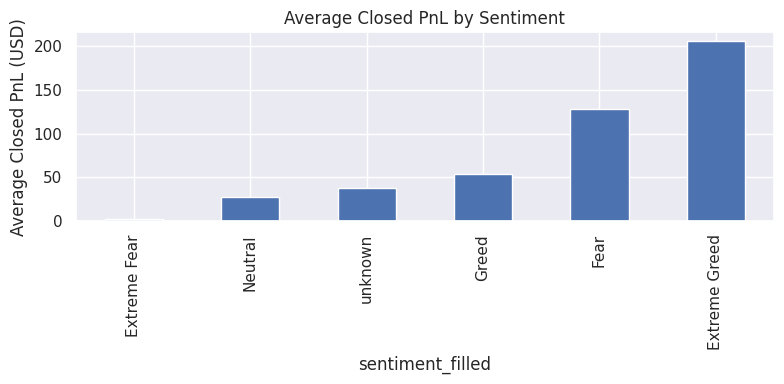

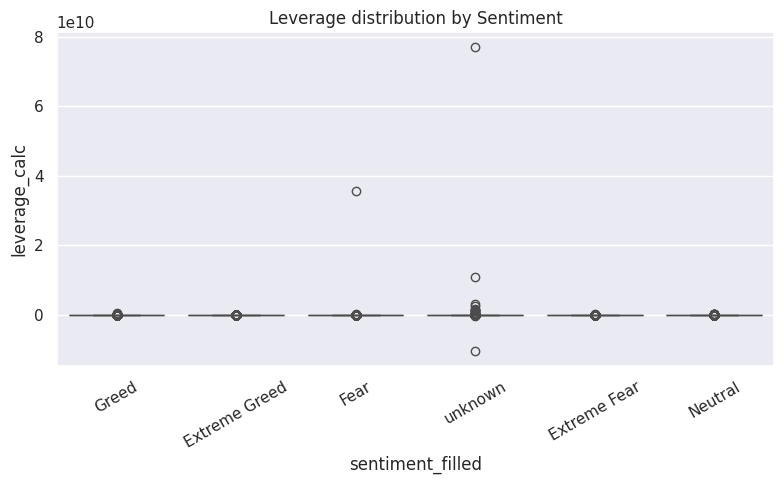

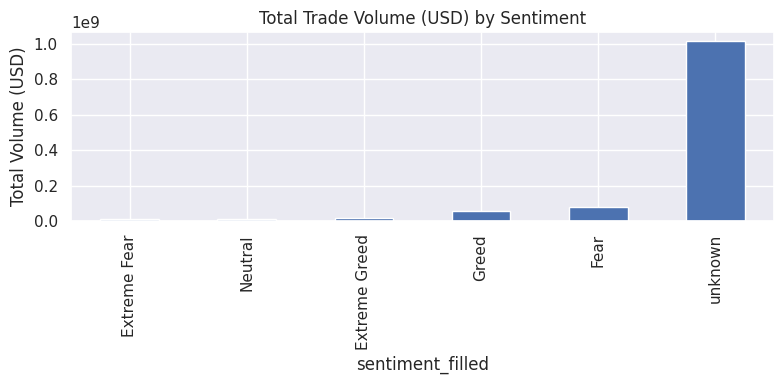

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

if 'avg_closed_pnl' in aggregates.columns:
    plt.figure(figsize=(8,4))
    aggregates['avg_closed_pnl'].sort_values().plot(kind='bar')
    plt.title('Average Closed PnL by Sentiment')
    plt.ylabel('Average Closed PnL (USD)')
    plt.tight_layout()
    plt.savefig('outputs/avg_pnl_by_sentiment.png')
    plt.show()

if leverage_col:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='sentiment_filled', y=leverage_col, data=merged)
    plt.title('Leverage distribution by Sentiment')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig('outputs/leverage_by_sentiment.png')
    plt.show()

if 'total_volume_usd' in aggregates.columns:
    plt.figure(figsize=(8,4))
    aggregates['total_volume_usd'].sort_values().plot(kind='bar')
    plt.title('Total Trade Volume (USD) by Sentiment')
    plt.ylabel('Total Volume (USD)')
    plt.tight_layout()
    plt.savefig('outputs/volume_by_sentiment.png')
    plt.show()
